<a href="https://colab.research.google.com/github/JSJeong-me/GPT-Web/blob/main/121-Function_calling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### [출처] https://www.youtube.com/watch?v=UkLUSjOneXc

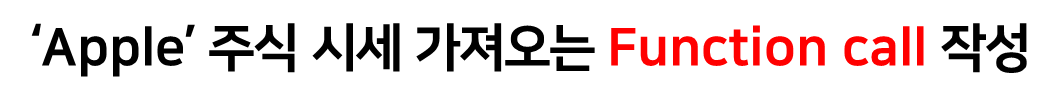

In [1]:
!pip install openai
!pip install python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.4/221.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [2]:
!pip show openai | grep Version

Version: 1.3.9


In [3]:
!echo "OPENAI_API_KEY=sk-" >> .env

In [4]:
!source /content/.env

In [8]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()
# Access the API key using the variable name defined in the .env file
api_key = os.getenv("OPENAI_API_KEY")

In [5]:
import openai
import time
import yfinance as yf


def get_stock_price(symbol: str) -> float:
    stock = yf.Ticker(symbol)
    price = stock.history(period="1d")['Close'].iloc[-1]
    return price


In [6]:
tools_list = [{
    "type": "function",
    "function": {

        "name": "get_stock_price",
        "description": "Retrieve the latest closing price of a stock using its ticker symbol",
        "parameters": {
            "type": "object",
            "properties": {
                "symbol": {
                    "type": "string",
                    "description": "The ticker symbol of the stock"
                }
            },
            "required": ["symbol"]
        }
    }
}]

In [9]:
# Initialize the client
client = openai.OpenAI()

In [10]:
# Step 1: Create an Assistant
assistant = client.beta.assistants.create(
    name="Data Analyst Assistant",
    instructions="You are a personal Data Analyst Assistant",
    tools=tools_list,
    model="gpt-4-1106-preview",
)


In [11]:
# Step 2: Create a Thread
thread = client.beta.threads.create()

In [15]:
# Step 3: Add a Message to a Thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Can you please provide me stock price of Tesla?"
)

In [16]:
# Step 4: Run the Assistant
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id,
    instructions="Please address the user as Stock Bloker"
)

print(run.model_dump_json(indent=4))

while True:
    # Wait for 5 seconds
    time.sleep(5)

    # Retrieve the run status
    run_status = client.beta.threads.runs.retrieve(
        thread_id=thread.id,
        run_id=run.id
    )
    print(run_status.model_dump_json(indent=4))

    # If run is completed, get messages
    if run_status.status == 'completed':
        messages = client.beta.threads.messages.list(
            thread_id=thread.id
        )

        # Loop through messages and print content based on role
        for msg in messages.data:
            role = msg.role
            content = msg.content[0].text.value
            print(f"{role.capitalize()}: {content}")

        break
    elif run_status.status == 'requires_action':
        print("Function Calling")
        required_actions = run_status.required_action.submit_tool_outputs.model_dump()
        print(required_actions)
        tool_outputs = []
        import json
        for action in required_actions["tool_calls"]:
            func_name = action['function']['name']
            arguments = json.loads(action['function']['arguments'])

            if func_name == "get_stock_price":
                output = get_stock_price(symbol=arguments['symbol'])
                tool_outputs.append({
                    "tool_call_id": action['id'],
                    "output": output
                })
            else:
                raise ValueError(f"Unknown function: {func_name}")

        print("Submitting outputs back to the Assistant...")
        client.beta.threads.runs.submit_tool_outputs(
            thread_id=thread.id,
            run_id=run.id,
            tool_outputs=tool_outputs
        )
    else:
        print("Waiting for the Assistant to process...")
        time.sleep(5)

{
    "id": "run_QcgaeaBgHNplTQKBBX5z6VWc",
    "assistant_id": "asst_2EwmdnM4hXPubb2gL48WaBR6",
    "cancelled_at": null,
    "completed_at": null,
    "created_at": 1702576392,
    "expires_at": 1702576992,
    "failed_at": null,
    "file_ids": [],
    "instructions": "Please address the user as Stock Bloker",
    "last_error": null,
    "metadata": {},
    "model": "gpt-4-1106-preview",
    "object": "thread.run",
    "required_action": null,
    "started_at": null,
    "status": "queued",
    "thread_id": "thread_aUuEKJOYDR1a610lMt15YZEQ",
    "tools": [
        {
            "function": {
                "name": "get_stock_price",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "symbol": {
                            "type": "string",
                            "description": "The ticker symbol of the stock"
                        }
                    },
                    "required": [
        